This code generates graphs that show what the predicted gel digest may look like. It requires the SNP location in the chr#_###### format, the sizes of the uncut and cut bands, and the allele that would allow the restriction enzyme to cut. Of note, this has only been tested on a few SNPs so far. It has not been tested how it handles multiple digests. Currently it is set up to work with hmp files encompassing inbreds and the output is for hybrids. This code was run using Python 3.11.4 but should work in any Python with pandas and matplotlib. THe script requires the user to know what form of the SNP allows the restriction enzyme in the CAPS/dCAPS assay to cut and what the sizes of the cut and uncut bands would be. Note: this code used a lot of generation from ChatGPT and may contain overlooked errors.

The following block of code installs pandas and matplotlib if not already installed:

In [1]:
!pip install pandas
!pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


The following script asks for the path to the HapMap file (.hmp).

In [22]:
hmp_file = input("Enter file path (e.g., /path/to/snps.hmp): ").strip()


The following interactive code prompts the user for the number of sites to have on the gel simulation. In most cases this will be 1 unless the user is interested in running multiple digestion products on the same well. The script asks for the RS ID of the SNP of interest, the allele that allows for digestion, the size of the undigested band, and the sizes of the digested bands.

In [30]:
def get_site_info(site_num):
    """Ask user for one site’s details."""
    print(f"\n--- Enter details for site {site_num} ---")
    
    rs = input("Enter site name / rs ID (e.g., chr7_177063073): ").strip()
    while not rs:
        rs = input("RS ID cannot be empty. Please enter again: ").strip()
    
    cutting_allele = input("Enter cutting allele (single letter, e.g., G): ").strip().upper()
    while len(cutting_allele) != 1 or not cutting_allele.isalpha():
        cutting_allele = input("Invalid allele. Enter a single letter (A/T/G/C): ").strip().upper()
    
    # Uncut size
    while True:
        try:
            uncut_size = int(input("Enter uncut fragment size (integer): "))
            if uncut_size > 0:
                break
            else:
                print("Must be a positive integer.")
        except ValueError:
            print("Please enter a valid integer.")
    
    # Cut sizes
    while True:
        cut_sizes_str = input("Enter cut fragment sizes separated by commas (e.g., 215,58): ")
        try:
            cut_sizes = [int(x.strip()) for x in cut_sizes_str.split(",") if x.strip()]
            if all(cs > 0 for cs in cut_sizes):
                break
            else:
                print("All cut sizes must be positive integers.")
        except ValueError:
            print("Please enter integers separated by commas.")
    
    return {
        "rs": rs,
        "cutting_allele": cutting_allele,
        "uncut_size": uncut_size,
        "cut_sizes": cut_sizes
    }


# === Interactive data entry ===
sites = []

num_sites = int(input("How many sites do you want to enter? "))

for i in range(1, num_sites + 1):
    sites.append(get_site_info(i))

# Editing loop
while True:
    print("\n=== Sites Entered ===")
    for i, s in enumerate(sites, 1):
        print(f"{i}. {s}")
    
    edit = input("\nDo you want to edit any site? (y/n): ").strip().lower()
    if edit == "y":
        try:
            site_num = int(input("Enter the site number to edit: "))
            if 1 <= site_num <= len(sites):
                sites[site_num - 1] = get_site_info(site_num)
            else:
                print("Invalid site number.")
        except ValueError:
            print("Please enter a valid site number.")
    else:
        break

print("\n=== Final Sites ===")
for s in sites:
    print(s)



--- Enter details for site 1 ---

--- Enter details for site 2 ---

--- Enter details for site 3 ---

=== Sites Entered ===
1. {'rs': 'chr7_177063073', 'cutting_allele': 'G', 'uncut_size': 227, 'cut_sizes': [116, 111]}
2. {'rs': 'chr4_18563972', 'cutting_allele': 'A', 'uncut_size': 273, 'cut_sizes': [215, 58]}
3. {'rs': 'chr3_3760684', 'cutting_allele': 'T', 'uncut_size': 221, 'cut_sizes': [179, 42]}

=== Final Sites ===
{'rs': 'chr7_177063073', 'cutting_allele': 'G', 'uncut_size': 227, 'cut_sizes': [116, 111]}
{'rs': 'chr4_18563972', 'cutting_allele': 'A', 'uncut_size': 273, 'cut_sizes': [215, 58]}
{'rs': 'chr3_3760684', 'cutting_allele': 'T', 'uncut_size': 221, 'cut_sizes': [179, 42]}


The following interactive code block asks the user for what set of genotypes they want in the simulated gel image, whether or not to include a negative control in the final lane, and whetehr or not to add labels to the subgroups (inbreds, type 1 hybrids, type 2 hybrids, type 3 hybrids, and NC).

Choose sample set:
1 - 6 inbreds only
2 - 9 hybrids only
3 - 6 inbreds + 9 hybrids
4 - Expanded hybrids (~30)


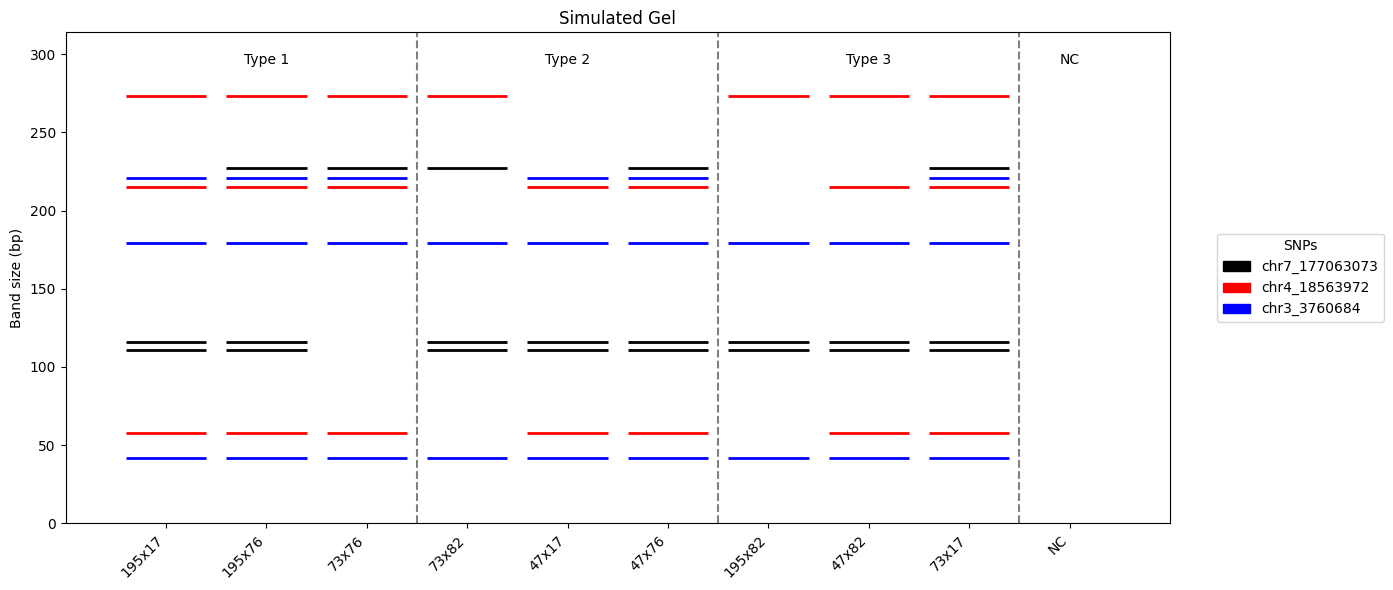

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colors = ["black", "red", "blue", "green", "purple"]

# === Sample Definitions ===
inbreds = ["B73", "LH195", "PHN82", "PHB47", "Mo17", "PHK76"]

nine_hybrids = ["195x17", "195x76", "73x76", "73x82", "47x17", "47x76", "195x82", "47x82", "73x17"]

expanded_hybrids = [
    "LH195 x Mo17", "LH195 x PHK76", "B73 x PHK76", "CR1HT x PHG72", "LH145 x LH82", "LH145 x PHG29",
    "NKH8431 x PH207", "PHB47 x PHG72", "PHB47 x PHZ51", "PHJ40 x PHG35", "PHW65 x PH207", "PHW65 x PHN11",
    "Seagull Seventeen x PHG35", "W604S x PH207", "B73 x PHN82", "PHB47 x Mo17", "PHB47 x PHK76", "B84 x PHN11",
    "CR1HT x PHG29", "PHB47 x PH207", "PHG47 x PHG72", "PHJ40 x PH207", "PHJ40 x PHN11", "Seagull Seventeen x PH207",
    "W604S x PHG72", "W604S x PHN11", "AS5707 x PHG35", "B84 x PHG50", "LH145 x PHN11", "PHW65 x PHG50",
    "Seagull Seventeen x PHG50", "LH195 x PHN82", "PHB47 x PHN82", "B73 x Mo17", "AS5707 x PHG72", "B84 x PHG29",
    "PHB47 x PHN82", "PHG29 x PHG47", "PHJ40 x PHG50"
]

exclude_parents = {"NKH8431", "LH244", "AS5707"}

# === Hybrid Code Map ===
hybrid_code_map = {
    "73": "B73",
    "195": "LH195",
    "82": "PHN82",
    "47": "PHB47",
    "17": "Mo17",
    "76": "PHK76"
}

# === IUPAC codes ===
iupac_codes = {
    "A": {"A"}, "C": {"C"}, "G": {"G"}, "T": {"T"},
    "R": {"A", "G"}, "Y": {"C", "T"}, "S": {"G", "C"}, "W": {"A", "T"},
    "K": {"G", "T"}, "M": {"A", "C"},
    "B": {"C", "G", "T"}, "D": {"A", "G", "T"}, "H": {"A", "C", "T"}, "V": {"A", "C", "G"},
    "N": {"A", "C", "G", "T"}
}

# === User Choices ===
print("Choose sample set:")
print("1 - 6 inbreds only")
print("2 - 9 hybrids only")
print("3 - 6 inbreds + 9 hybrids")
print("4 - Expanded hybrids (~30)")
choice = int(input("Enter 1-4: "))

include_nc = input("Include negative control (y/n)? ").lower() == "y"

dashed_lines = input("Include dashed separators (y/n)? ").lower() == "y"

# === Define samples based on choice ===
if choice == 1:
    samples = inbreds
elif choice == 2:
    samples = nine_hybrids
elif choice == 3:
    samples = inbreds + nine_hybrids
elif choice == 4:
    samples = [h for h in expanded_hybrids if not any(p in exclude_parents for p in h.split(" x "))]
else:
    raise ValueError("Invalid choice")

if include_nc:
    samples = samples + ["NC"]

# === Load SNP data ===
df = pd.read_csv(hmp_file, sep="\t", low_memory=False)
df.columns = df.columns.astype(str)

# === Helper function ===
def allele_has_cut(allele, cutting_allele):
    return cutting_allele in iupac_codes.get(allele, set())

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 6))
ax.invert_yaxis()
ax.set_xlim(-1, len(samples))
color_legend = []

for i, site in enumerate(sites):
    rs, cutting_allele, uncut_size, cut_sizes = site["rs"], site["cutting_allele"], site["uncut_size"], site["cut_sizes"]
    row = df[df["rs#"] == rs]
    if row.empty:
        print(f"SNP {rs} not found in HMP.")
        continue
    row = row.iloc[0]

    gel_patterns = {}
    for sample in samples:
        if sample == "NC":
            gel_patterns[sample] = []
        elif sample in inbreds:
            allele = row[sample]
            gel_patterns[sample] = cut_sizes if allele_has_cut(allele, cutting_allele) else [uncut_size]
        elif "x" in sample:
            parents = [p.strip() for p in sample.split("x")]
            if len(parents) != 2:
                continue
            p1 = hybrid_code_map.get(parents[0], parents[0])
            p2 = hybrid_code_map.get(parents[1], parents[1])

            if p1 in exclude_parents or p2 in exclude_parents:
                gel_patterns[sample] = []
            else:
                allele1, allele2 = row[p1], row[p2]
                cut1, cut2 = allele_has_cut(allele1, cutting_allele), allele_has_cut(allele2, cutting_allele)
                if cut1 and cut2:
                    gel_patterns[sample] = cut_sizes
                elif not cut1 and not cut2:
                    gel_patterns[sample] = [uncut_size]
                else:
                    gel_patterns[sample] = [uncut_size] + cut_sizes

    color = colors[i % len(colors)]
    for idx, sample in enumerate(samples):
        for band in gel_patterns.get(sample, []):
            ax.hlines(band, idx - 0.4, idx + 0.4, color=color, linewidth=2)

    if len(sites) > 1:
        color_legend.append(mpatches.Patch(color=color, label=rs))

# === Final touches ===
ax.set_ylim(0, 1.15 * max(s["uncut_size"] for s in sites))
ax.set_xticks(range(len(samples)))
ax.set_xticklabels(samples, rotation=45, ha="right")
ax.set_ylabel("Band size (bp)")
ax.set_title("Simulated Gel")

if len(sites) > 1:
    ax.legend(handles=color_legend, title="SNPs", loc="center right", bbox_to_anchor=(1.2, 0.5))

# === Custom separators & labels ===
if "uncut_size" in sites[0]:  # safety check that sites are defined
    max_band = max([s["uncut_size"]] + s["cut_sizes"] for s in sites)
    max_band = max([val for sublist in max_band for val in (sublist if isinstance(sublist, list) else [sublist])])
    ymax = max_band * 1.15
    ax.set_ylim(0, ymax)

    if dashed_lines:
        label_height = max_band * 1.075

        if choice == 2:  # 9 hybrids
            ax.axvline(x=2.5, linestyle="--", color="gray")
            ax.axvline(x=5.5, linestyle="--", color="gray")
            ax.text(1, label_height, "Type 1", ha="center")
            ax.text(4, label_height, "Type 2", ha="center")
            ax.text(7, label_height, "Type 3", ha="center")

        elif choice == 3:  # inbreds + 9 hybrids
            ax.axvline(x=5.5, linestyle="--", color="gray")
            ax.axvline(x=8.5, linestyle="--", color="gray")
            ax.axvline(x=11.5, linestyle="--", color="gray")
            ax.text(2.5, label_height, "Inbreds", ha="center")
            ax.text(7, label_height, "Type 1", ha="center")
            ax.text(10, label_height, "Type 2", ha="center")
            ax.text(13, label_height, "Type 3", ha="center")

        elif choice == 4:  # expanded hybrids
            ax.axvline(x=12.5, linestyle="--", color="gray")
            ax.axvline(x=24.5, linestyle="--", color="gray")
            ax.text(5.5, label_height, "Type 1", ha="center")
            ax.text(18.5, label_height, "Type 2", ha="center")
            ax.text(30.5, label_height, "Type 3", ha="center")

            ymin, ymax2 = ax.get_ylim()
            ax.add_patch(mpatches.Rectangle((24.5, ymin), 4, ymax2-ymin, facecolor="yellow", alpha=0.3))
            ax.text(26.5, label_height, "Variable", fontsize=8, ha="center")

# === Negative control label ===
if include_nc:
    nc_pos = len(samples) - 1
    ax.text(nc_pos, max_band * 1.075, "NC", ha="center")
    ax.axvline(x=nc_pos-.5, linestyle="--", color="gray")

plt.tight_layout()
plt.show()
